In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import hammerstein

## System
Define the system and calculate input and output signals

In [2]:
nsamples = 2**11
noiselevel = 0.0

def m(u):
    #return (1-np.exp(-np.abs(u)))*np.sign(u)
    return u**2
def lbda(n):
    if n < 0:
        return 0.0
    elif n > 1000:
        return 0.0
    elif n == 25:
        return 0.7
    else:
        return 1.0/1.1**n

lbda = np.vectorize(lbda)


inputsignal = np.random.randn(nsamples)
pureout = np.zeros(nsamples)

for n in range(nsamples):
    pureout[n] = np.sum( m(inputsignal[0:n+1]) * lbda(np.r_[n:-1:-1]) )
    
noiseout = pureout + noiselevel*np.max(np.abs(pureout))*np.random.randn(nsamples)


## Non-linear approximation
Define parameters for the approximation of the non-linearity, and perform the calculations.
This part uses the raw input and output algorithms, with a rectangular kernel $K$.

For non-linearities which $m(0)=0$ we can shift the approximation by $\mu(0)$ This will be true for all acoustic non-linearities.

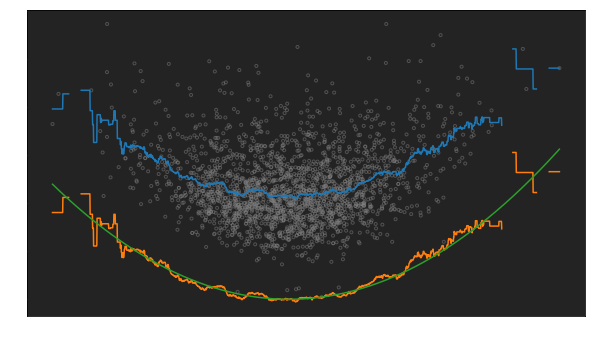

In [3]:
approxPoints, mu = hammerstein.nonlinearApproximation(inputsignal,noiseout,shift=False)
closezero = np.searchsorted(approxPoints,0)
if -approxPoints[closezero-1] < approxPoints[closezero]:
    closezero -=1
muShift = mu - mu[closezero]
finIdx = np.isfinite(muShift)
muFun = interp1d(approxPoints[finIdx],muShift[finIdx])

plt.scatter(inputsignal,noiseout,marker='.',facecolor='none',edgecolor='gray',alpha=0.5)
plt.plot(approxPoints,mu)
plt.plot(approxPoints,muShift)
plt.plot(approxPoints,m(approxPoints))
plt.show()

## Linear system approximation
Approximate the parameter $\kappa$, proportional to the dynamic impulse response of the linear system.
This part uses the proposed algorithm without compensating for the non-linear system.

$\kappa$ can be normalized by dividing by the first element. This will give a better appoximation if the original impulse response has unity gain for the first element.

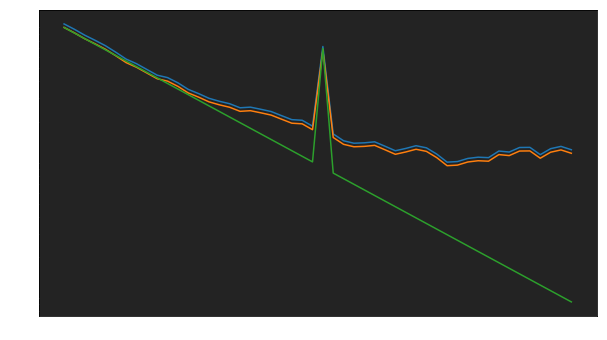

In [111]:
kappa = hammerstein.linearApproximation(inputsignal, noiseout, nonlinearFun = muFun, len = 50)
lbdaApprox = kappa/kappa[0]

plt.semilogy(np.abs(kappa))
plt.semilogy(np.abs(lbdaApprox))
plt.semilogy(np.abs(lbda(np.arange(kappa.size))))
plt.show()

